## Importaciones

In [ ]:
import os
from openai import OpenAI
from dotenv import load_dotenv
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import f1_score, classification_report, multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer

## Carga de datos

En este apartado se realiza la carga de datos de la competencia se crea una nueva columna `labels` donde se estructuran los valores de la columna `group`
por ejemplo:  neurologial|hepatorenal en forma de lista como ['neurological','hepatorenal']
esto con el objetivo que sea mucho mas facil hacer la clasificación multietiquetas mas adelante.

In [ ]:
df = pd.read_csv("../data/dataset.csv", sep=";")

# Crear columna de etiquetas como listas
df["labels"] = df["group"].str.split("|")

# Lista de todas las clases únicas
all_labels = sorted(set(label for labels in df["labels"] for label in labels))
print(all_labels)

['cardiovascular', 'hepatorenal', 'neurological', 'oncological']


## Api OpenIA

Este proyecto implementa un sistema de clasificación automática de artículos médicos en múltiples categorías utilizando la API de OpenAI y el modelo gpt-4o-mini. La solución está diseñada para procesar grandes volúmenes de texto de manera eficiente mediante un esquema de trabajo por lotes, en el que cada grupo de artículos se transforma a un formato JSON seguro y se envía al modelo junto con instrucciones claras y ejemplos de salida.

La respuesta del modelo, que se obtiene en formato JSON válido, se procesa y valida para asegurar que solo contenga etiquetas previamente definidas en all_labels. Una vez validadas, estas etiquetas se integran en el DataFrame original en una columna dedicada `(group_predicted)`, respetando el enfoque multietiqueta, en el que cada artículo puede tener varias categorías asignadas.

In [ ]:
## open_ia_model

# Cargar variables de entorno desde .env
load_dotenv()

# Inicializar el cliente sin pasar manualmente la key
client = OpenAI()

In [ ]:
import json  # Asegúrate de que json está importado


def classify_batch_of_articles(batch_df, classes):
    """
    Clasifica un lote de artículos en una sola llamada a la API.
    Esta versión está corregida y es más robusta.
    """
    articles_formatted = []
    for index, row in batch_df.iterrows():
        # Crear un diccionario de Python por cada artículo
        article_data = {"id": index, "title": row["title"], "abstract": row["abstract"]}
        # Usar json.dumps para convertir el diccionario a una cadena JSON válida
        # Esto maneja automáticamente caracteres especiales como comillas y saltos de línea.
        articles_formatted.append(json.dumps(article_data))

    # Unir los artículos en una sola cadena, separados por coma y nueva línea
    articles_str = ",\n".join(articles_formatted)

    prompt = f"""
    You are an expert medical article classifier.
    Your task is to assign one or more relevant labels to a list of articles.
    The available labels are: {classes}

    You will receive a JSON array of articles. For each article, determine the appropriate labels.
    Return ONLY a valid JSON object where keys are the article IDs (as strings) and values are an array of corresponding labels.

    Example response format:
    {{
      "123": ["neurological"],
      "124": ["cardiovascular", "oncological"],
      "125": ["cardiovascular", "oncological",'neurological']
      "126": ['cardiovascular', 'hepatorenal', 'neurological', 'oncological']
    }}

    Here is the list of articles to classify:
    [{articles_str}]
    """

    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "system",
                    "content": "You are an expert medical article classifier designed to output JSON.",
                },
                {"role": "user", "content": prompt},
            ],
            temperature=0,
            response_format={"type": "json_object"},
        )
        content = response.choices[0].message.content
        predicted_json = json.loads(content)
        return {int(k): v for k, v in predicted_json.items()}

    except Exception as e:
        print(f"An error occurred during API call: {e}")
        return {}

In [ ]:
from tqdm import tqdm
import numpy as np

BATCH_SIZE = 100  # cuantos texto va a procesar el modelo por peticion
all_predictions = {}

# Dividir el DataFrame en lotes usando numpy
batches = np.array_split(df, len(df) // BATCH_SIZE + 1)

for batch in tqdm(batches, desc="Classifying batches"):
    if not batch.empty:
        # Obtener las predicciones para el lote actual
        batch_predictions = classify_batch_of_articles(batch, all_labels)
        # Añadir las predicciones al diccionario global
        all_predictions.update(batch_predictions)

# Mapear las predicciones de vuelta al DataFrame
df["group_predicted"] = df.index.map(all_predictions)

df["group_predicted"] = df["group_predicted"].apply(
    lambda x: x if isinstance(x, list) else []
)

# Ahora puedes verificar el resultado
print(df[["labels", "group_predicted"]].head())

c:\Users\Juan Felipe\Documents\GitHub\techspere_data_challenge\venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Classifying batches: 100%|██████████| 36/36 [08:14<00:00, 13.74s/it]

                        labels              group_predicted
0  [neurological, hepatorenal]               [neurological]
1               [neurological]  [oncological, neurological]
2                [hepatorenal]                [hepatorenal]
3               [neurological]               [neurological]
4               [neurological]  [oncological, neurological]


## Evaluacion de resultados

En la evaluación, el modelo alcanzó un Accuracy_score del 42%, un resultado esperado en tareas multietiqueta por su alto nivel de exigencia. Las métricas F1 (micro y weighted) rondan el 63%, lo que demuestra un desempeño sólido y balanceado en general.La matriz de consufion por clases muestra buen rendimiento en categorías como neurological y cardiovascular, aunque hay margen de mejora en clases menos representadas como oncological.

In [ ]:
# Crear un binarizador multietiqueta usando una lista de todas las clases posibles.
mlb = MultiLabelBinarizer(classes=all_labels)

# Transformar la columna 'labels' del DataFrame en una matriz binaria.
y_true = mlb.fit_transform(df["labels"])
y_pred = mlb.transform(df["group_predicted"])

In [ ]:
# Exact Match Ratio
exact_match = accuracy_score(y_true, y_pred)
print(f"acurracy: {exact_match:.4f}")

# F1-Score micro, macro y weighted
print("F1 Micro:", f1_score(y_true, y_pred, average="micro"))
print("F1 Macro:", f1_score(y_true, y_pred, average="macro"))
print("F1 Weighted:", f1_score(y_true, y_pred, average="weighted"))

# Reporte completo
print(
    "\nClassification Report:\n",
    classification_report(y_true, y_pred, target_names=all_labels),
)

acurracy: 0.4247
F1 Micro: 0.6331065759637188
F1 Macro: 0.6192052198985907
F1 Weighted: 0.6399088842999927

Classification Report:
                 precision    recall  f1-score   support

cardiovascular       0.76      0.65      0.70      1268
   hepatorenal       0.87      0.42      0.57      1091
  neurological       0.84      0.57      0.68      1785
   oncological       0.40      0.82      0.53       601

     micro avg       0.69      0.59      0.63      4745
     macro avg       0.71      0.61      0.62      4745
  weighted avg       0.77      0.59      0.64      4745
   samples avg       0.70      0.64      0.64      4745



c:\Users\Juan Felipe\Documents\GitHub\techspere_data_challenge\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


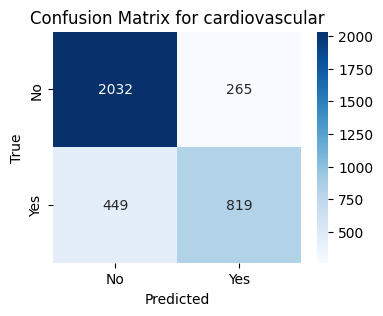

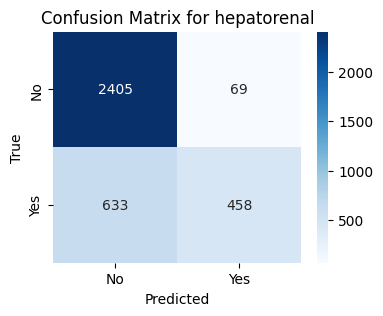

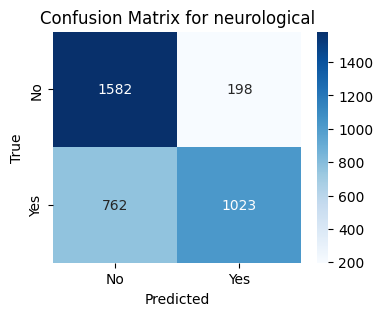

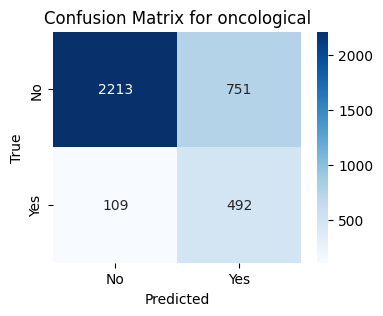

In [ ]:
# Construcion matrix de confusion
mcm = multilabel_confusion_matrix(y_true, y_pred)

for i, label in enumerate(all_labels):
    cm = mcm[i]
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["No", "Yes"],
        yticklabels=["No", "Yes"],
    )
    plt.title(f"Confusion Matrix for {label}")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()